### Application of GPcounts with Negative Binomial likelihood on spatial data from Mouse olfactory bulb to identify spatially expressed genes. 

In the following example, we use Mouse olfactory bulb spatially dependent data-set, published by <a href="https://science.sciencemag.org/content/353/6294/78" target="_blank">Stahl et al.</a>. 
To correct for the library size of the spatial samples, we normalise our data by multiplying the mean by a location specific scale factor. To calculate the scale factors we perform negative binomial regression with identity link function using R glm package. The scale factors are saved in ./data/MouseOB/scales_nb.txt. The R script is available in ./data/MouseOB/nb_regression.R  


In [1]:
import pandas as pd 
import numpy as np 
import gpflow
import tensorflow as tf
from GPcounts.GPcounts_Module import Fit_GPcounts
from matplotlib import pyplot as plt

We load the expression matrix and extract the spatial locations 'x' and 'y'

In [2]:
# spatial expression counts matrix
Y = pd.read_csv('../data/MouseOB/Rep11_MOB_0.csv', index_col=[0])
Y = Y.T[Y.sum(0) >= 3].T # Filter out genes with less than 3 total counts

In [3]:
spatial_locations = pd.DataFrame(index=Y.index)
spatial_locations['x'] = Y.index.str.split('x').str.get(0).map(float)
spatial_locations['y'] = Y.index.str.split('x').str.get(1).map(float)

In [4]:
spatial_locations['total_counts'] = Y.sum(1)
Y = Y.loc[spatial_locations.index]
X = spatial_locations[['x', 'y']]
scale = pd.read_csv('../data/MouseOB/scales_nb.txt', sep="\t") # load the file with the scale factors 

After filtering, the whole data-set contains 14,859 genes but for simplicity we run this example on the first 20 genes. This will take a few minutes. For the purposes of comparison, we provide a file (../data/MouseOB/SE_genes_comparison.csv) with the all spatially expressed genes found by running GPcounts on the whole data-set as well as the spatially expressed genes identified by [SpatialDE](https://github.com/Teichlab/SpatialDE/tree/cb5deb8c24e7c98c77672784b43cef41b2f24d99) package.    

In [5]:
Y = Y.T
Y_run = Y.iloc[0:20,:] # select first 20 genes to run GPcounts
X = X[['x', 'y']]

To run the scaled version of the GPcounts, where the negative binomial mean is multiplied by the pre-culculated scale factors, we should use the optional argument in the function Fit_GPcounts:  'scale=scale'.
The 'scale' argument contains the file with the scale factors.

In [6]:
gene_name = []
gene_name = Y_run.index
likelihood = 'Negative_binomial' 
gp_counts = Fit_GPcounts(X,Y_run.loc[gene_name], scale = scale,safe_mode=False)

We run the One_sample_test with negative binomial likelihood for the 20 genes. The results will show the following:

* Name of the gene
* Dynamic_model_log_likelihood - Likelihood of the dynamic model  
* Constant_model_log_likelihood - Likelihood of the constant ('null') model
* log_likelihood_ratio - Ratio between the dynamic and constant models
* p value - statistical significance based on P value 
* q value - Statistical significance based on the "adjusted p value" for the false discovery rate or q value 

In [7]:
log_likelihood_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

  0%|                                                    | 0/20 [00:00<?, ?it/s]2022-02-01 11:02:49.395306: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-01 11:02:49.527525: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
100%|███████████████████████████████████████████| 20/20 [06:11<00:00, 18.58s/it]


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
Nrf1,-2873.398679,-4989.722481,2116.323803
Zbtb5,-3003.924157,-5287.833997,2283.909840
Ccnl1,-6228.871783,-9742.027917,3513.156134
Lrrfip1,-4890.107916,-8532.621389,3642.513473
Bbs1,-4974.807066,-7994.985598,3020.178531
Lix1,-8830.392531,-12852.326390,4021.933860
Whrn,-3740.772630,-6888.657431,3147.884801
Ate1,-6853.131867,-10385.530979,3532.399112
Ubac1,-7135.941549,-10636.405808,3500.464259
Rab34,-5040.360320,-8088.687540,3048.327220


In [8]:
results = gp_counts.calculate_FDR(log_likelihood_ratio)
results

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,p_value,q_value
Nrf1,-2873.398679,-4989.722481,2116.323803,0.000000,0.000000
Zbtb5,-3003.924157,-5287.833997,2283.909840,0.000000,0.000000
Ccnl1,-6228.871783,-9742.027917,3513.156134,0.000000,0.000000
Lrrfip1,-4890.107916,-8532.621389,3642.513473,0.000000,0.000000
Bbs1,-4974.807066,-7994.985598,3020.178531,0.000000,0.000000
Lix1,-8830.392531,-12852.326390,4021.933860,0.000000,0.000000
Whrn,-3740.772630,-6888.657431,3147.884801,0.000000,0.000000
Ate1,-6853.131867,-10385.530979,3532.399112,0.000000,0.000000
Ubac1,-7135.941549,-10636.405808,3500.464259,0.000000,0.000000
Rab34,-5040.360320,-8088.687540,3048.327220,0.000000,0.000000


Plot some spatially expressed genes from the data-set based on the q values provided in file 'SE_genes_comparison.csv'

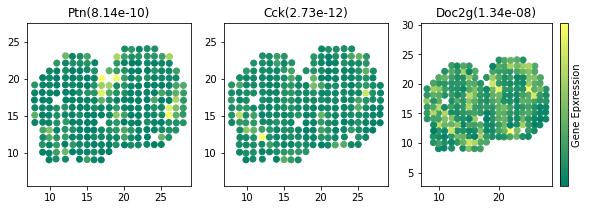

In [9]:
from matplotlib import rcParams
plt.rcParams["figure.figsize"] = [10,3]
m = ['Ptn(8.14e-10)', 'Cck(2.73e-12)', 'Doc2g(1.34e-08)']
for i, g in enumerate(['Ptn', 'Cck', 'Doc2g']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(spatial_locations['x'], spatial_locations['y'], c=Y.T[g],cmap = 'summer')
    # plt.figure(figsize=(10,3))
    plt.title(m[i])
    plt.axis('equal')
plt.colorbar(ticks=[0,1],label = 'Gene Epxression')

plt.show()


 We plot two genes with very low expression which have been identified as spatially expressed by SpatialDE but not by GPcounts 

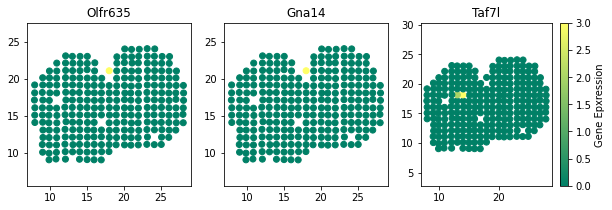

In [10]:
plt.rcParams["figure.figsize"] = [10,3]
n = ['Olfr635','Gna14', 'Taf7l']
for i, g in enumerate(['Olfr635','Gna14', 'Taf7l']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(spatial_locations['x'], spatial_locations['y'], c=Y.T[g],cmap = 'summer')
    # plt.figure(figsize=(10,3))
    plt.title(n[i])
    plt.axis('equal')
plt.colorbar(label = 'Gene Epxression')